# Projeto Predição de Carros

## Importações

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree,  export_graphviz
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, multilabel_confusion_matrix, classification_report

## Consumo
A base utilizada é composta por caracteristicas de um carro e sua avaliação dada essas caracteristicas. São elas:

- compra: valor de compra classificado em low, med, high ou vhigh
- manutencao: valor de manutencao classificado em low, med, high ou vhigh
- portas: quantidade de portas que o veículo possui sendo 2, 3, 4 ou 5more
- porta-malas: tamanho do porta-mala classificado em small, med ou big
- seguranca: nivel de segurança do carro classificado em low, med ou high
- avaliacao: a avalição que um carro pode receber:
    - unnac(inaceitável), 
    - accep(aceitável),
    - good(bom)
    - vgood(muito bom)

In [2]:
df_carros = pd.read_csv("dadosCarro.csv")
display(df_carros.head())

,compra,manutencao,portas,pessoas,porta-malas,seguranca,avaliacao
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Separação X e Y

In [3]:
x = df_carros.drop("avaliacao",axis=1)
y = df_carros[["avaliacao"]]

In [20]:
display(x)
display(y)

,compra,manutencao,portas,pessoas,porta-malas,seguranca
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med
...,...,...,...,...,...,...
1723,low,low,5more,more,med,med
1724,low,low,5more,more,med,high
1725,low,low,5more,more,big,low
1726,low,low,5more,more,big,med


,avaliacao
0,unacc
1,unacc
2,unacc
3,unacc
4,unacc
...,...
1723,good
1724,vgood
1725,unacc
1726,good


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8, random_state=42, shuffle=True)

In [11]:
pipeline = Pipeline([
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("categoricas", OrdinalEncoder(), make_column_selector(dtype_include=["object", "bool"]))
        ], 
        remainder="passthrough", 
        verbose_feature_names_out=False
    )),
    ("classifier", DecisionTreeClassifier(
        criterion="gini",
        max_depth=None,
        max_features=None,
        min_samples_leaf=1,
        min_samples_split=2,
        splitter="best"
    ))
])

pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categoricas',
                                                  OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C349098250>)],
                                   verbose_feature_names_out=False)),
                ('classifier', DecisionTreeClassifier())])

In [13]:
y_pred = pipeline.predict(x_test)

Gini
               precision    recall  f1-score   support

         acc       0.97      0.92      0.94        83
        good       0.62      0.91      0.74        11
       unacc       1.00      1.00      1.00       235
       vgood       1.00      0.94      0.97        17

    accuracy                           0.97       346
   macro avg       0.90      0.94      0.91       346
weighted avg       0.98      0.97      0.98       346



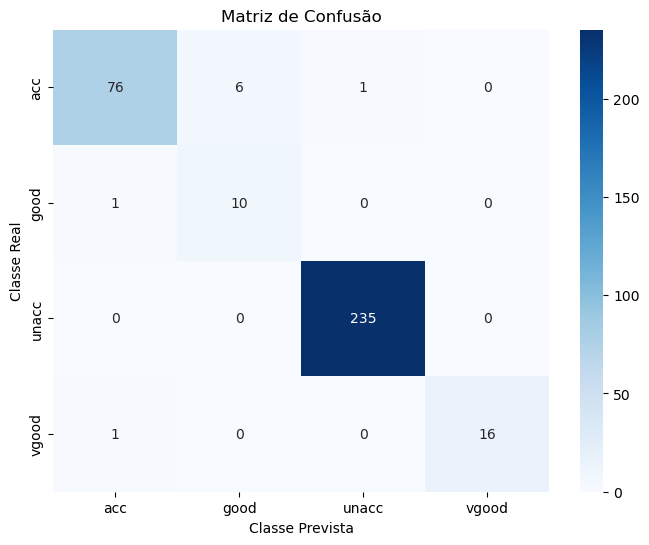

In [15]:
classes = pipeline[1].classes_
print("Gini\n", classification_report(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

# Decision Tree

In [12]:
model_gini = DecisionTreeClassifier(criterion="gini")
model_entropy = DecisionTreeClassifier(criterion="entropy")
model_logloss = DecisionTreeClassifier(criterion="log_loss")

## KFold

In [21]:
SEED=0
metricas = ["accuracy", "f1_weighted"]
cv = KFold(n_splits=4, shuffle=True, random_state=SEED)

print("\nEntropy")
for i in metricas:
    print(f"Métrica - {i}")
    score = cross_val_score(model_entropy,x.values,y.values,cv=cv, scoring=i)
    print(score,score.mean())

print("\nGini")
for i in metricas:
    print(f"Métrica - {i}")
    score = cross_val_score(model_gini,x.values,y.values,cv=cv, scoring=i)
    print(score,score.mean())

print("\nLog Loss")    
for i in metricas:
    print(f"Métrica - {i}")
    score = cross_val_score(model_logloss,x.values,y.values,cv=cv, scoring=i)
    print(score,score.mean())


Entropy
Métrica - accuracy
[0.97685185 0.98148148 0.96064815 0.96527778] 0.9710648148148149
Métrica - f1_weighted
[0.97708406 0.98096301 0.96033806 0.96953587] 0.9719802499778724

Gini
Métrica - accuracy
[0.9837963  0.97916667 0.96296296 0.97453704] 0.9751157407407407
Métrica - f1_weighted
[0.97927763 0.97870868 0.95783049 0.9671556 ] 0.970743101592072

Log Loss
Métrica - accuracy
[0.98148148 0.98148148 0.96064815 0.96990741] 0.9733796296296297
Métrica - f1_weighted
[0.97948097 0.98096301 0.96033806 0.97647957] 0.9743154018063038


In [22]:
(train_index, test_index) = tuple(cv.split(df_carros))[0]
x_train, y_train, x_test, y_test = x.iloc[train_index,:], y.iloc[train_index,:], x.iloc[test_index,:], y.iloc[test_index,:]

(train_index, test_index) = tuple(cv.split(df_carros))[1]
x_train_logloss, y_train_logloss, x_test_logloss, y_test_logloss = x.iloc[train_index,:], y.iloc[train_index,:], x.iloc[test_index,:], y.iloc[test_index,:]

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.75, random_state=0)

## Treinamento

In [24]:
model_entropy.fit(x_train, y_train)
model_gini.fit(x_train, y_train)
model_logloss.fit(x_train_logloss, y_train_logloss)

DecisionTreeClassifier(criterion='log_loss')

In [27]:
# fig = plt.figure(figsize=(30,7))
# plot_tree(model_entropy, 
#                    feature_names=x.columns,  
#                    class_names=model_entropy.classes_,
#                    filled=True)

In [28]:
# fig = plt.figure(figsize=(30,7))
# plot_tree(model_gini, 
#                    feature_names=x.columns,  
#                    class_names=model_gini.classes_,
#                    filled=False)

In [29]:
# fig = plt.figure(figsize=(30,7))
# plot_tree(model_logloss, 
#                    feature_names=x.columns,  
#                    class_names=model_gini.classes_,
#                    filled=False)

In [30]:
# import graphviz
# import os
# os.environ["PATH"] += os.pathsep + "C:/Users/guilhermebarbosa-ieg/OneDrive - Instituto Germinare/2TECH/ADD/DecisionTree/Graphviz-11.0.0-win64/bin"
# arvore_entropy = export_graphviz(model_entropy, 
#                               feature_names=x.columns, 
#                               class_names=model_entropy.classes_, 
#                               filled=True)

# graph = graphviz.Source(arvore_entropy, format="png")
# graph

## Teste

In [25]:
predict_entropy = model_entropy.predict(x_test)
predict_gini = model_gini.predict(x_test)
predict_logloss = model_logloss.predict(x_test_logloss)

## Avaliação

Entropia
               precision    recall  f1-score   support

         acc       0.98      0.92      0.95        99
        good       0.81      1.00      0.89        21
       unacc       0.99      1.00      0.99       296
       vgood       1.00      0.94      0.97        16

    accuracy                           0.98       432
   macro avg       0.94      0.96      0.95       432
weighted avg       0.98      0.98      0.98       432



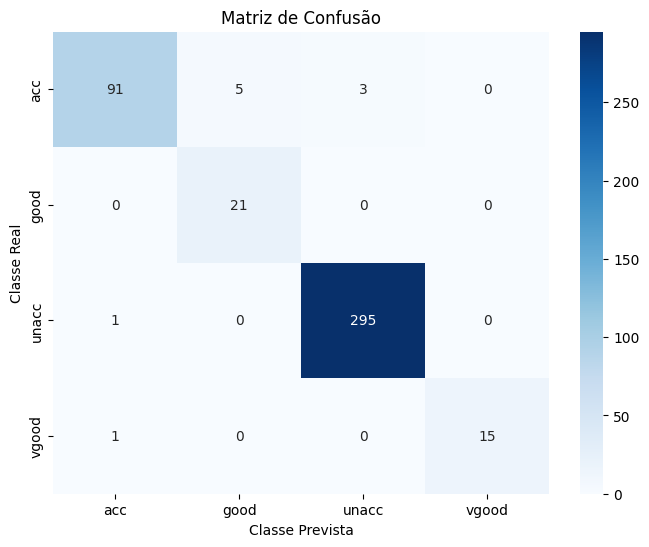

Gini
               precision    recall  f1-score   support

         acc       0.98      0.93      0.95        99
        good       0.84      1.00      0.91        21
       unacc       0.99      1.00      0.99       296
       vgood       1.00      0.94      0.97        16

    accuracy                           0.98       432
   macro avg       0.95      0.97      0.96       432
weighted avg       0.98      0.98      0.98       432



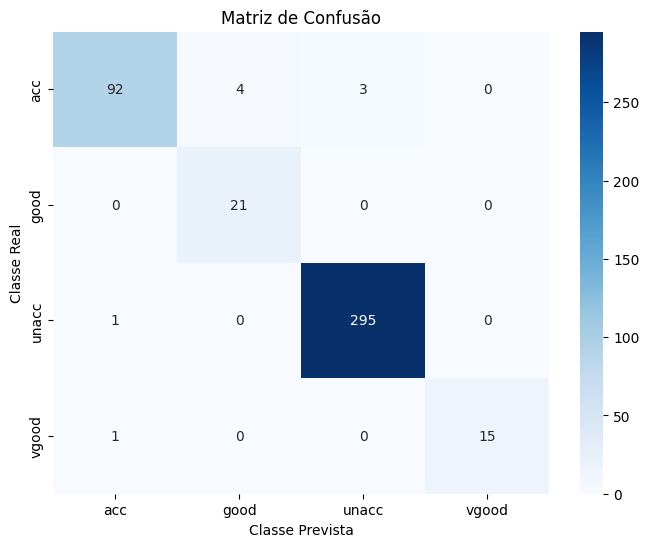

Log Loss
               precision    recall  f1-score   support

         acc       0.97      0.96      0.96        94
        good       1.00      0.73      0.84        11
       unacc       0.98      0.99      0.98       303
       vgood       1.00      1.00      1.00        24

    accuracy                           0.98       432
   macro avg       0.99      0.92      0.95       432
weighted avg       0.98      0.98      0.98       432



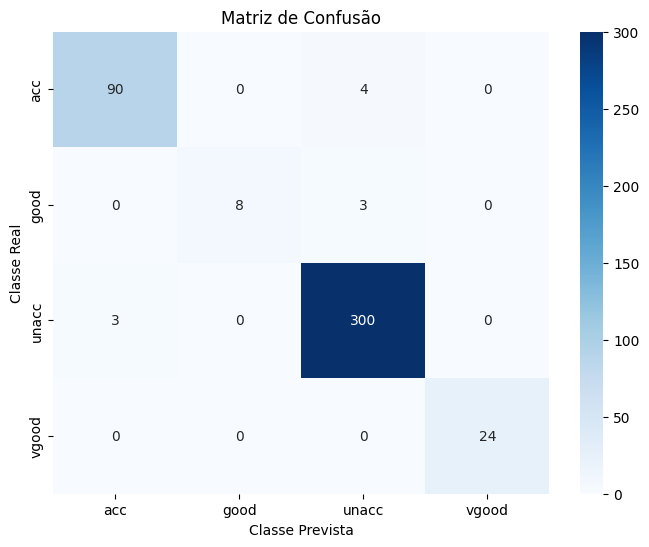

In [26]:
classes = model_entropy.classes_

print("Entropia\n", classification_report(y_test, predict_entropy))
matrix = confusion_matrix(y_test, predict_entropy)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

print("Gini\n", classification_report(y_test, predict_gini))
matrix = confusion_matrix(y_test, predict_gini)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

print("Log Loss\n", classification_report(y_test_logloss, predict_logloss))
matrix = confusion_matrix(y_test_logloss, predict_logloss)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

In [33]:
def inverter_matriz(matrix):
    v1,v2,v3,v4 = matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]
    nova_matrix = np.array([[v4, v3],
                   [v2, v1]])
    return nova_matrix

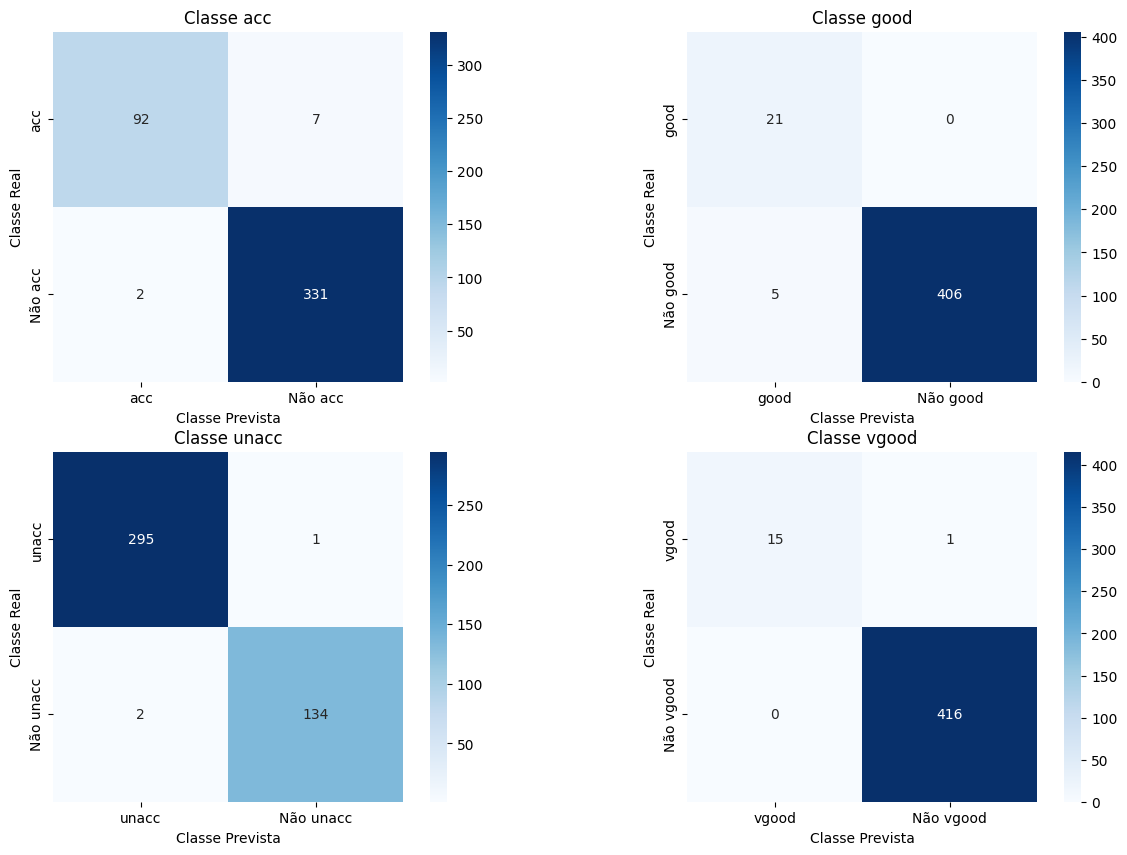

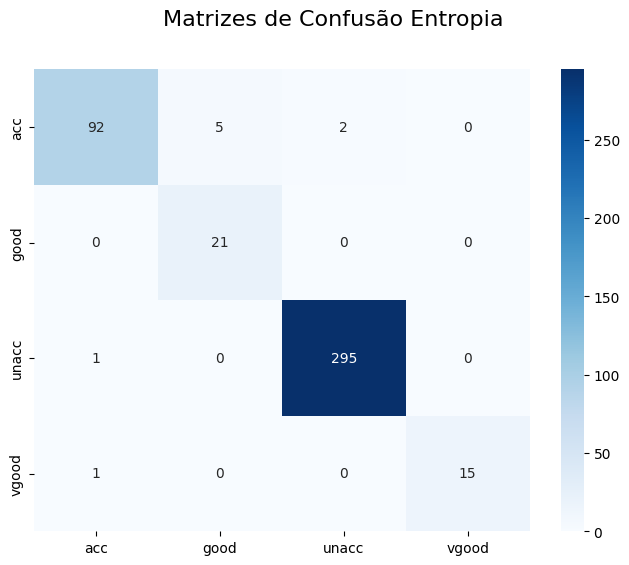

In [34]:
matrix = confusion_matrix(y_test, predict_entropy)
confusion_matrix_each = multilabel_confusion_matrix(y_test, predict_entropy, labels=classes)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, j, k,l in zip(confusion_matrix_each, classes, [0, 0, 1, 1,2], [0,1,0,1,0]):
    
    if k==0==l:
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
        axs[k, l].set_title(f"Classe {j}")
        axs[k, l].set_xlabel("Classe Prevista")
        axs[k, l].set_ylabel("Classe Real")
    
    lista = [j, "Não " + j]
    
    i_inverted = inverter_matriz(i)

    axs[k, l].imshow(i_inverted, cmap='Blues')
    sns.heatmap(i_inverted, annot=True, fmt='g', cmap='Blues', xticklabels=lista, yticklabels=lista, ax=axs[k,l])
    axs[k, l].set_title(f"Classe {j}")
    axs[k, l].set_xlabel("Classe Prevista")
    axs[k, l].set_ylabel("Classe Real")
    
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.suptitle("Matrizes de Confusão Entropia", fontsize=16)    
plt.show()

# Ajuste de parâmetros

In [35]:
model_entropy.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [36]:
model_entropy.tree_.max_depth

13

In [37]:
model_entropy.tree_.node_count

157

In [38]:
def train_test_tree(model_gini, model_entropy): 

    x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.75,random_state=42)

    model_entropy.fit(x_train, y_train)
    model_gini.fit(x_train, y_train)

    y_train_predict_entropy = model_entropy.predict(x_train)
    y_train_predict_gini = model_gini.predict(x_train)

    y_test_predict_entropy = model_entropy.predict(x_test)
    y_test_predict_gini = model_gini.predict(x_test)

    print("TREINO")
    print("Gini: ", round(accuracy_score(y_train, y_train_predict_gini),2),"%")
    print("Entropia: ", round(accuracy_score(y_train, y_train_predict_entropy),2),"%")

    print("TESTE")
    print("Gini: ", round(accuracy_score(y_test, y_test_predict_gini),2),"%")
    print("Entropia: ", round(accuracy_score(y_test, y_test_predict_entropy),2),"%")


In [39]:
train_test_tree(model_gini, model_entropy)

TREINO
Gini:  1.0 %
Entropia:  1.0 %
TESTE
Gini:  0.97 %
Entropia:  0.98 %


## Splitter

In [40]:
#splitter igual a best - definir nó com base na melhor gini/entropia
model_gini = DecisionTreeClassifier(criterion="gini", splitter="best")
model_entropy = DecisionTreeClassifier(criterion="entropy", splitter="best")
train_test_tree(model_gini, model_entropy)

#definir nó de maneira aleatória
model_gini = DecisionTreeClassifier(criterion="gini", splitter="random")
model_entropy = DecisionTreeClassifier(criterion="entropy", splitter="random")
train_test_tree(model_gini, model_entropy)


TREINO
Gini:  1.0 %
Entropia:  1.0 %
TESTE
Gini:  0.97 %
Entropia:  0.97 %
TREINO
Gini:  1.0 %
Entropia:  1.0 %
TESTE
Gini:  0.98 %
Entropia:  0.95 %


## Max depth

In [41]:
#profundidade máxima de 10 
model_gini = DecisionTreeClassifier(criterion="gini", max_depth=10)
model_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=10)
train_test_tree(model_gini, model_entropy)

#profundidade máxima de 5 
model_gini = DecisionTreeClassifier(criterion="gini", max_depth=5)
model_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=5)
train_test_tree(model_gini, model_entropy)

#profundidade máxima de 2 
model_gini = DecisionTreeClassifier(criterion="gini", max_depth=2)
model_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=2)
train_test_tree(model_gini, model_entropy)

TREINO
Gini:  0.99 %
Entropia:  0.99 %
TESTE
Gini:  0.96 %
Entropia:  0.97 %
TREINO
Gini:  0.87 %
Entropia:  0.87 %
TESTE
Gini:  0.88 %
Entropia:  0.88 %
TREINO
Gini:  0.77 %
Entropia:  0.77 %
TESTE
Gini:  0.75 %
Entropia:  0.75 %


## Min Samples Split

In [42]:
#máximo de 10 amostras para criar nós
model_gini = DecisionTreeClassifier(criterion="gini", min_samples_split=5)
model_entropy = DecisionTreeClassifier(criterion="entropy", min_samples_split=5)
train_test_tree(model_gini, model_entropy)

#máximo de 10 amostras para criar nós
model_gini = DecisionTreeClassifier(criterion="gini", min_samples_split=10)
model_entropy = DecisionTreeClassifier(criterion="entropy", min_samples_split=10)
train_test_tree(model_gini, model_entropy)

#máximo de 10 amostras para criar nós
model_gini = DecisionTreeClassifier(criterion="gini", min_samples_split=20)
model_entropy = DecisionTreeClassifier(criterion="entropy", min_samples_split=20)
train_test_tree(model_gini, model_entropy)


TREINO
Gini:  0.99 %
Entropia:  0.99 %
TESTE
Gini:  0.96 %
Entropia:  0.96 %


TREINO
Gini:  0.98 %
Entropia:  0.98 %
TESTE
Gini:  0.94 %
Entropia:  0.95 %
TREINO
Gini:  0.96 %
Entropia:  0.96 %
TESTE
Gini:  0.94 %
Entropia:  0.95 %


## Min Samples Leaf

## Max features

## Grid Search CV

In [27]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion':['gini', 'entropy'],
    'splitter':['best','random'],
    'max_depth':[None, 2, 4, 6, 8, 10, 12],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 5, 10],
    'max_features':[None, 'sqrt', 'log2']
}

cv = KFold(n_splits=4, shuffle=True, random_state=SEED)
grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params, scoring='accuracy', refit=True, cv=cv)

In [28]:
grid.fit(x_train, y_train)

print("Melhores Hiperparâmetros: ", grid.best_score_)
print("Melhor Acurácia: ", grid.best_params_)

y_pred_grid = grid.predict(x_test)
print(classification_report(y_test, y_pred_grid))

Melhores Hiperparâmetros:  0.9645061728395061
Melhor Acurácia:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
              precision    recall  f1-score   support

         acc       0.98      0.93      0.95        99
        good       0.84      1.00      0.91        21
       unacc       0.99      1.00      0.99       296
       vgood       1.00      0.94      0.97        16

    accuracy                           0.98       432
   macro avg       0.95      0.97      0.96       432
weighted avg       0.98      0.98      0.98       432



In [29]:
predict_train = grid.predict(x_train)
print("Entropia: ", round(accuracy_score(y_train, predict_train),2),"%")


Entropia:  1.0 %


In [30]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [31]:
best_tree = DecisionTreeClassifier(**grid.best_params_)
best_tree.fit(x_train, y_train)

DecisionTreeClassifier()

## Job Lib - Serialização

Agora tanto o modelo como o encoder devem passar por um processo de serialização, ou seja, eles devem ser armazenados com uma "memória" do que já foram treinados

In [1]:
import joblib as jb

jb.dump(best_tree, "predict_car.joblib")
jb.dump(preprocessador,"preprocessador.joblib")

NameError: name 'best_tree' is not defined

In [14]:
import joblib as jb
from sklearn.pipeline import make_pipeline
import pandas as pd

best_tree_load = jb.load("./predict_car.joblib")
preprocessador_load = jb.load("./preprocessador.joblib")

In [19]:
registro = pd.DataFrame(
        data=[["vhigh","vhigh", "2", "2", "small", "low"]],
        columns=["compra", "manutencao", "portas", "pessoas", "porta-malas", "seguranca"]
    )

pipeline = make_pipeline(preprocessador_load.transform(), best_tree_load.predict())
pipeline.predict(registro)

TypeError: ColumnTransformer.transform() missing 1 required positional argument: 'X'